In [1]:
import pyuvdata
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("/opt/devel/rbyrne/rlb_LWA/LWA_data_preprocessing")
from LWA_calibrate import read_caltable_safely
from casatools import table

ModuleNotFoundError: No module named '_image'

In [ ]:
cal = read_caltable_safely(
    "/lustre/pipeline/calibration/results/2026-01-12/05h/successful/20260115_130732/tables/calibration_2026-01-12_05h.B.flagged"
)

In [ ]:
def plot_all_spws(table_path, antenna_name, pol=0, time_idx=0):
    """
    Plots Amplitude vs Frequency for all Spectral Windows in a CASA table.
    """
    tb = table()

    # 1. Map Antenna Name to ID
    tb.open(table_path + "/ANTENNA")
    ant_names = tb.getcol("NAME")
    tb.close()
    ant_id = np.where(ant_names == antenna_name)[0][0]

    # 2. Get all unique SPWs present in the main table
    tb.open(table_path)
    # Filter for the specific antenna first
    ant_table = tb.query(f"ANTENNA1 == {ant_id}")
    all_spws = np.unique(ant_table.getcol("SPECTRAL_WINDOW_ID"))
    ant_table.close()
    tb.close()

    plt.figure(figsize=(12, 7))
    colors = plt.cm.viridis(np.linspace(0, 1, len(all_spws)))

    # 3. Loop through each SPW and plot
    for i, spw in enumerate(all_spws):
        # Get Frequencies for this SPW
        tb.open(table_path + "/SPECTRAL_WINDOW")
        chan_freqs = tb.getcell("CHAN_FREQ", spw) / 1e9  # Convert to GHz
        tb.close()

        # Extract Data and Flags for this specific SPW and Antenna
        tb.open(table_path)
        sub_tb = tb.query(f"ANTENNA1 == {ant_id} AND SPECTRAL_WINDOW_ID == {spw}")

        data = sub_tb.getcol("CPARAM").astype(complex)
        flags = sub_tb.getcol("FLAG")
        sub_tb.close()
        tb.close()

        # Apply flags as NaN
        data[flags] = np.nan + 1j * np.nan

        # Plot the specific polarization and time index
        # Slice: [Polarization, Channel, Time]
        plt.plot(
            chan_freqs,
            np.abs(data[pol, :, time_idx]),
            label=f"SPW {spw}",
            color=colors[i],
            linewidth=1.5,
        )

    plt.title(f"Full Bandpass Profile: {antenna_name} (Pol {pol})")
    plt.xlabel("Frequency (GHz)")
    plt.ylabel("Amplitude")
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", ncol=2)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_all_spws(
    "/lustre/pipeline/calibration/results/2026-01-12/05h/successful/20260115_130732/tables/calibration_2026-01-12_05h.B.flagged",
    "LWA176",
    pol=0,
    time_idx=0,
)

In [29]:
uncalib_data = pyuvdata.UVData()
uncalib_data.read_ms("/fast/rbyrne/20260112_120008-120158_34MHz.ms", data_column="DATA")

casa_calib_data = pyuvdata.UVData()
casa_calib_data.read_ms(
    "/fast/rbyrne/20260112_120008-120158_34MHz.ms", data_column="CORRECTED_DATA"
)

pyuvdata_calib_data = pyuvdata.UVData()
pyuvdata_calib_data.read_ms(
    "/fast/rbyrne/20260112_120008-120158_34MHz_05h_cal_calibrated.ms"
)

Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array. Largest imaginary component was 4.0, largest imaginary/real ratio was 9.915889620515372e-08.


In [31]:
uncalib_data.data_array[np.where(uncalib_data.flag_array)] = 0+0*1j
casa_calib_data.data_array[np.where(casa_calib_data.flag_array)] = 0 + 0 * 1j
pyuvdata_calib_data.data_array[np.where(pyuvdata_calib_data.flag_array)] = 0 + 0 * 1j

In [34]:
np.sum(casa_calib_data.flag_array)

np.int64(388103197)

In [35]:
np.sum(pyuvdata_calib_data.flag_array)

np.int64(281789243)

In [32]:
hist_uncalib, bin_edges = np.histogram(np.abs(uncalib_data.data_array.flatten()), bins=100)
hist_calib, bin_edges = np.histogram(
    np.abs(pyuvdata_calib_data.data_array.flatten()), bins=bin_edges
)
hist_calib_casa, bin_edges = np.histogram(
    np.abs(casa_calib_data.data_array.flatten()), bins=bin_edges
)

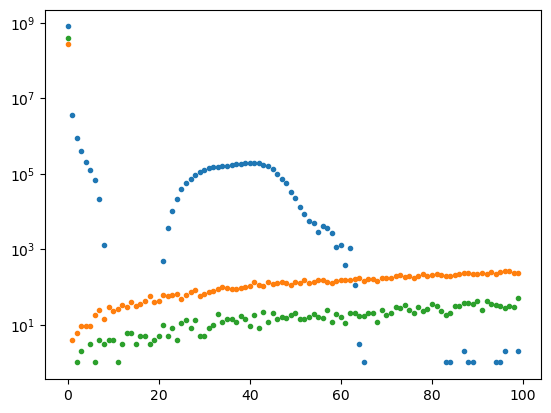

In [33]:
plt.plot(hist_uncalib, ".")
plt.plot(hist_calib, ".")
plt.plot(hist_calib_casa, ".")
plt.yscale("log")

In [15]:
cal = pyuvdata.UVCal()
cal.read("/fast/rbyrne/20260112_120008_46MHz.bcal")

Setting telescope_location to value in known_telescopes for OVRO-LWA.
Unknown polarization basis for solutions, jones_array values may be spurious.
Unknown x_orientation basis for solutions, assuming "east".


In [17]:
uv_uncalib = pyuvdata.UVData()
uv_uncalib.read("/fast/rbyrne/20260112_120008_46MHz.ms", data_column="DATA")
uv_casa_calib = pyuvdata.UVData()
uv_casa_calib.read(
    "/fast/rbyrne/20260112_120008_46MHz.ms", data_column="CORRECTED_DATA"
)

The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 6.754023659677557 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 6.754023659677557 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array. Largest imaginary component was 0.5, largest imaginary/real ratio was 8.793314520971762e-08.


In [18]:
uv_pyuvdata_calib = pyuvdata.utils.uvcalibrate(
    uv_uncalib, cal, inplace=False, time_check=False
)

gain_scale is not set, so there is no way to know what the resulting units are. For now, we assume that `gain_scale` matches whatever is on the UVData object (i.e. we do not change its units). Furthermore, all corrections concerning the pol_convention will be ignored.
pol_convention is not specified on the UVCal object, and uvc_pol_convention was not specified. Tentatively assuming that the UVCal and UVData objects (implicitly) have the same convention.
Neither uvd_pol_convention nor uvc_pol_convention are specified, so the resulting UVData object will have ambiguous convention. 
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 6.754023659677557 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.


In [26]:
uv_pyuvdata_calib.data_array[np.where(uv_pyuvdata_calib.flag_array)] = 0 +1j*0
uv_casa_calib.data_array[np.where(uv_casa_calib.flag_array)] = 0 + 1j * 0

In [27]:
hist_uncalib, bin_edges = np.histogram(
    np.abs(uv_uncalib.data_array.flatten()), bins=100
)
hist_calib, bin_edges = np.histogram(
    np.abs(uv_pyuvdata_calib.data_array.flatten()), bins=bin_edges
)
hist_calib_casa, bin_edges = np.histogram(
    np.abs(uv_casa_calib.data_array.flatten()), bins=bin_edges
)

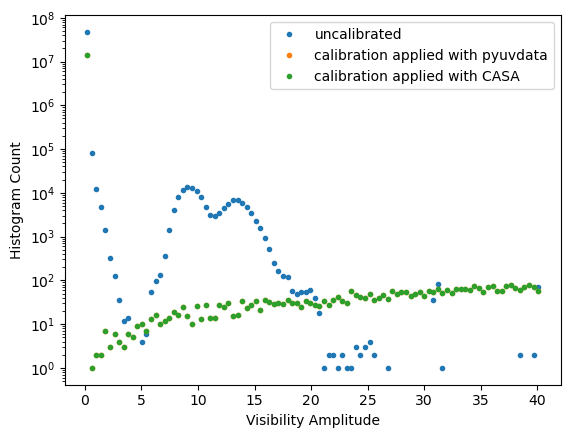

In [28]:
bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
plt.plot(bin_centers, hist_uncalib, ".", label="uncalibrated")
plt.plot(bin_centers, hist_calib, ".", label="calibration applied with pyuvdata")
plt.plot(bin_centers, hist_calib_casa, ".", label="calibration applied with CASA")
plt.yscale("log")
plt.xlabel("Visibility Amplitude")
plt.ylabel("Histogram Count")
plt.legend()

In [24]:
np.sum(uv_pyuvdata_calib.flag_array)

np.int64(14107304)

In [25]:
np.sum(uv_casa_calib.flag_array)

np.int64(14107304)